In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import csv
from IPython.display import display
from scipy.stats import pearsonr

In [11]:
#Os arquivos a serem utilizados foram importados do Kaggle mas vieram em arquivos distintos para cada ano, então esse bloco de código visa fazer a unificação dos arquivos e a inserção de uma coluna para cada indicar o ano do dado, de forma a trabalhar com eles em conjunto

arquivos = []

for arquivo in os.listdir("./worldHapinessReport2023"):
    if arquivo.endswith(".csv"):
        arquivos.append(arquivo)

#print(arquivos)

#Esse bloco de código usa como "novidade" ao que foi passado nas aulas apenas a biblioteca os que navega nas pastas e acessa arquivos. Aqui criamos um laço simples com o "for in" para que o os.listdir crie uma lista com os arquivos existentes e, para arquivos finalizados em .csv adicione como um item à lista criada na variável  arquivos.

In [14]:
#Agora vamos carregar os dados e adicionar uma coluna do ano (porque essa informação não existe nos arquivos originais, uma vez que cada arquivo está individualizado por ano)

dataframes = []

for arquivo in arquivos:
    ano = int(arquivo.split("_")[1].split(".")[0]) #divide o nome do arquivo para pegar apenas o ano
    df = pd.read_csv(os.path.join("./worldHapinessReport2023", arquivo)) #cria um caminho direto para ler cada um dos arquivos
    df["Year"] = ano #cria uma coluna ano em cada dataframe e adiciona nele o ano
    dataframes.append(df) # armazena as informações na lista da variável dataframes
    #print(df.shape)

(158, 10)
(157, 10)
(155, 10)
(156, 10)
(156, 10)
(153, 10)
(149, 10)
(137, 10)
(146, 10)


In [168]:
#Nessa etapa optamos por unificar os dataframes

df_unificado = pd.concat(dataframes, ignore_index=True) #Função concat do pandas pega os df armazenados em dataframes e unifica em um único dataframe
df_unificado.to_csv("./WHR_2015_a_2023.csv", index=False) #Salvamos esse novo dataframe como um novo arquivo
df_unificado.describe() #Aqui verificamos como ficou esse df

,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,Year
count,1367.000000,1367.000000,1367.000000,1366.000000,1367.000000,1367.000000,1366.000000,1367.000000
mean,5.441086,1.019422,1.045334,0.584043,0.450771,0.196260,0.132275,2018.903438
std,1.117909,0.453703,0.331163,0.245117,0.156733,0.113301,0.112555,2.561006
min,1.859000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,4.599500,0.696326,0.832022,0.402301,0.356000,0.115000,0.056826,2017.000000
50%,5.440000,1.043000,1.083000,0.612830,0.467610,0.182700,0.097000,2019.000000
75%,6.256300,1.338473,1.299985,0.777614,0.568685,0.252858,0.165945,2021.000000
max,7.842000,2.209000,1.644000,1.141000,0.772000,0.838075,0.587000,2023.000000


In [18]:
#Essa etapa vai criar também um arquivo .db com base nesse novo .csv que foi criado
#Aqui foram usados os conceitos aprendidos nas aulas, com a diferença de que foi utilizado o pandas para passar as informações do df_unificado para sql, que foi algo que não tinha sido passado ainda.
#Foi utilizada a biblioteca do pandas para entender como a função "to_sql" funciona

conn = sqlite3.connect("world_hapiness_2015_2023.db")
df_unificado.to_sql("worldHapiness", conn, if_exists="replace", index=False)
conn.close

<function Connection.close()>

In [71]:
#Essa etapa vai verificar se tem algum valor nulo no dataframe em alguma coluna.
print(df_unificado.isnull().sum())


country                         0
region                          0
happiness_score                 0
gdp_per_capita                  0
social_support                  0
healthy_life_expectancy         1
freedom_to_make_life_choices    0
generosity                      0
perceptions_of_corruption       1
Year                            0
dtype: int64


In [73]:
# Como o insnull indicou a existência de valores nulos, quisemos analisar quais séries (linhas) eram essas e se estava OK deletá-las. Para isso pesquisamos formas de exibir no terminal os valores mais formatados e encontramos a função display que permite exibir o DataFrame de forma mais formatada.

# Abaixo a linha de código que cria uma variável pra exibir todas as linhas onde qualquer coluna tenha um valor NaN
linhas_com_na = df_unificado[df_unificado.isnull().any(axis=1)]

# Mostrar DataFrame formatado
display(linhas_com_na)

,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,Year
645,United Arab Emirates,Middle East and North Africa,6.774,2.096,0.776,0.67,0.284,0.186,NaN,2018
1182,State of Palestine,Middle East and North Africa,4.908,1.144,1.309,NaN,0.416,0.065,0.067,2023


In [74]:
#Abaixo a função para verificar se há dados duplicados no DataFrame.

print(df_unificado.duplicated().sum())

#A consulta sobre duplicados não retornou nenhum dado. Dessa forma, foi possível prosseguir com as análises.

0


In [28]:
#Nessa etapa fizemos uma consulta em SQL, para analisar quantos dados tínhamos por ano.

conn = sqlite3.connect("world_hapiness_2015_2023.db")
cursor = conn.cursor()

cursor.execute(
    """
    SELECT year,
    COUNT(country)
    FROM worldHapiness
    GROUP BY Year
    """
)

results = cursor.fetchall()
print("Ano, Número de países")
for linha in results:
    print(linha)

conn.close()

#Essa consulta permitiu verificar que não temos o mesmo número de países em todos os anos, o que leva à necessidade de fazer um tratamento para analisar apenas os países que aparecem em todos os anos, dependendo das análises que formos fazer.

Ano, Número de países
(2015, 158)
(2016, 157)
(2017, 155)
(2018, 156)
(2019, 156)
(2020, 153)
(2021, 149)
(2022, 146)
(2023, 137)


# ETAPA DOS GRÁFICOS

1. Gráfico que exibe a relação do score de felicidade global ao longo dos anos:

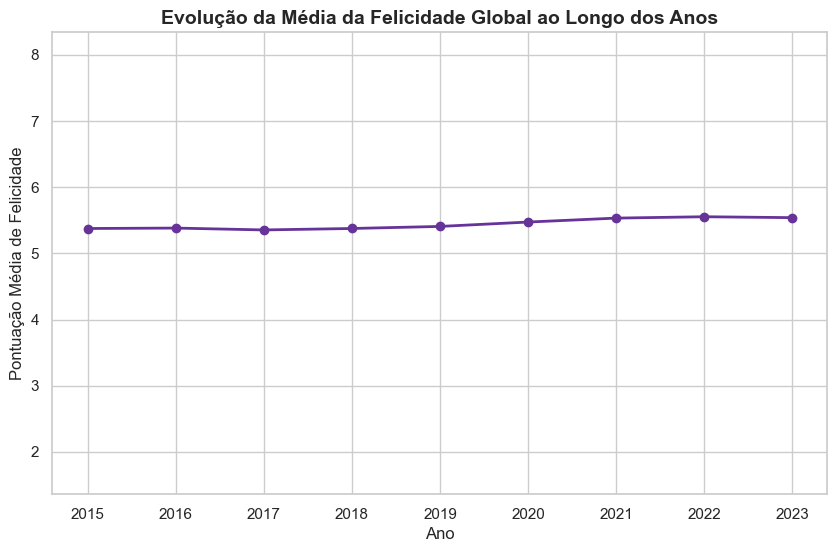

In [104]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))# Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
df_unificado.groupby('Year')["happiness_score"].mean().plot(kind='line', linewidth=2, marker="o", color="rebeccapurple")# Agrupa o DataFrame `df_unificado` pelo ano e calcula a média da coluna 'Score' para cada ano.

#Como o gráfico inicial ficou com a escala muito próxima, achamos que não permitiu ver essa evolução real, então ajustamos os valores no eixo Y:
plt.ylim(df_unificado["happiness_score"].min() - 0.5, df_unificado["happiness_score"].max() + 0.5)


plt.title('Evolução da Média da Felicidade Global ao Longo dos Anos', fontsize=14, fontweight="bold")# Define o título do gráfico
plt.xlabel('Ano')# Define o rótulo do eixo x
plt.ylabel('Pontuação Média de Felicidade')# Define o rótulo do eixo y
plt.grid(True)# Adiciona uma grade ao fundo do gráfico para facilitar a leitura dos valores
plt.show() # Exibe o gráfico na tela

2. Gráfico que exibe a relação entre a pontuação da felicidade e o PIB (GDP)

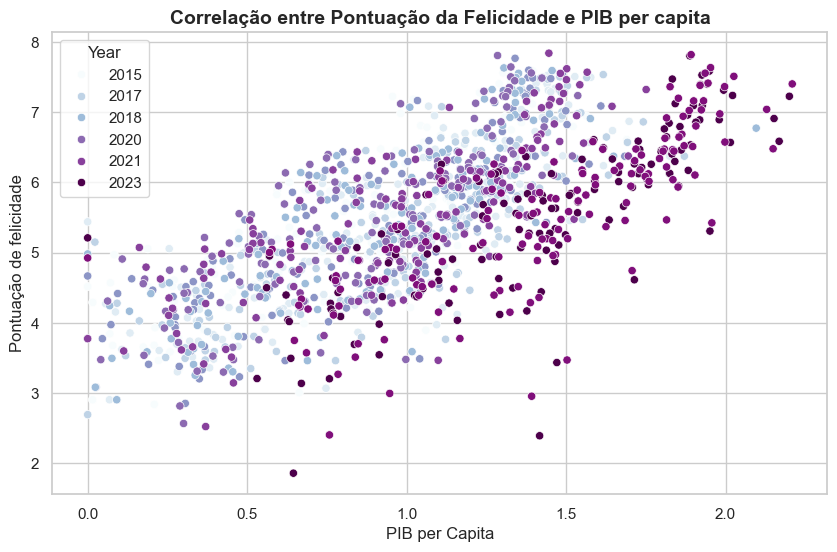

In [159]:
plt.figure(figsize=(10, 6))  # Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
sns.scatterplot(x='gdp_per_capita', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu')  # Cria um gráfico no eixo x e 'Score' no eixo y, usando os dados do DataFrame
plt.title("Correlação entre Pontuação da Felicidade e PIB per capita", fontsize=14, fontweight="bold")  # Define o título do gráfico
plt.xlabel('PIB per Capita')  # Define o rótulo do eixo x
plt.ylabel("Pontuação de felicidade")  # Define o rótulo do eixo y


plt.show()  # Exibe o gráfico na tela


3. Gráfico da Correlação da Felicidade com a Liberdade de Decisão

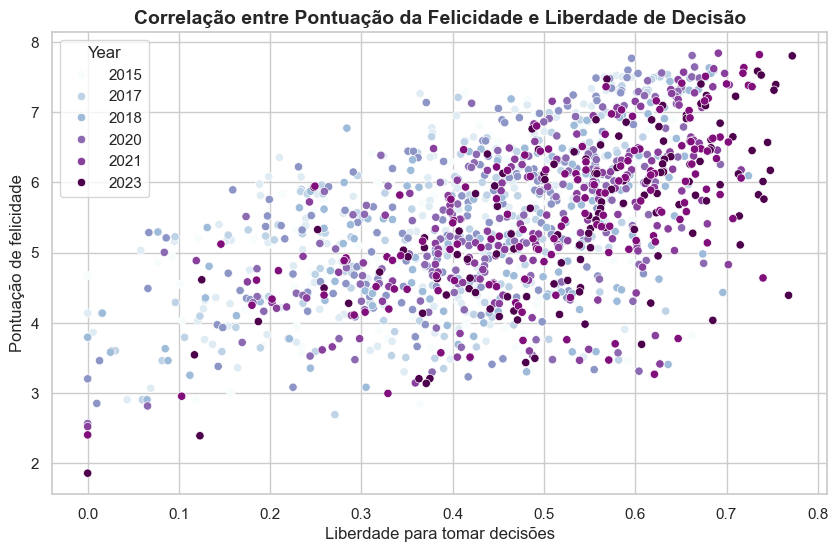

In [138]:
plt.figure(figsize=(10, 6))  # Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
sns.scatterplot(x='freedom_to_make_life_choices', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu')  # Cria um gráfico no eixo x e 'Score' no eixo y, usando os dados do DataFrame
plt.title("Correlação entre Pontuação da Felicidade e Liberdade de Decisão", fontsize=14, fontweight="bold")  # Define o título do gráfico
plt.xlabel('Liberdade para tomar decisões')  # Define o rótulo do eixo x
plt.ylabel("Pontuação de felicidade")  # Define o rótulo do eixo y


plt.show()  # Exibe o gráfico na tela

4. Gráfico da correlação entre Felicidade e Suporte Social

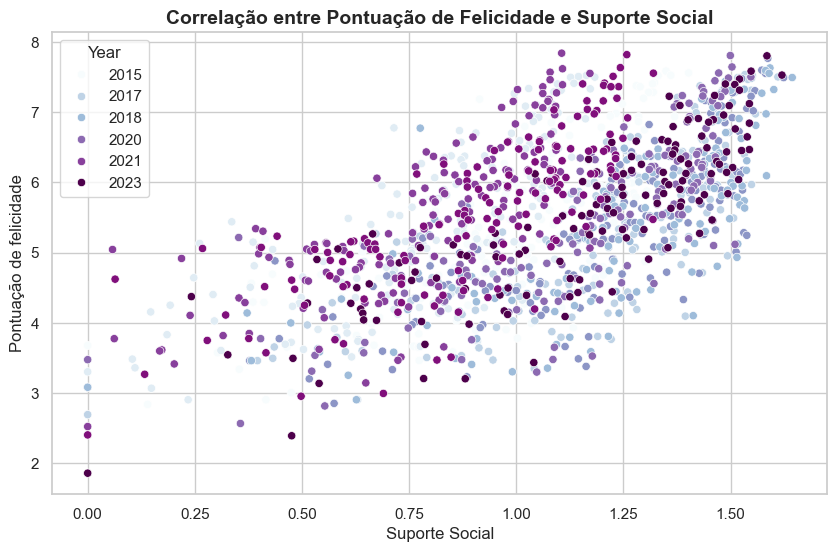

In [139]:
plt.figure(figsize=(10, 6))  # Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
sns.scatterplot(x='social_support', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu')  # Cria um gráfico no eixo x e 'Score' no eixo y, usando os dados do DataFrame
plt.title("Correlação entre Pontuação de Felicidade e Suporte Social", fontsize=14, fontweight="bold")  # Define o título do gráfico
plt.xlabel('Suporte Social')  # Define o rótulo do eixo x
plt.ylabel("Pontuação de felicidade")  # Define o rótulo do eixo y


plt.show()  # Exibe o gráfico na tela

5. Gráfico da correlação entre felicidade e expectativa de vida saudável

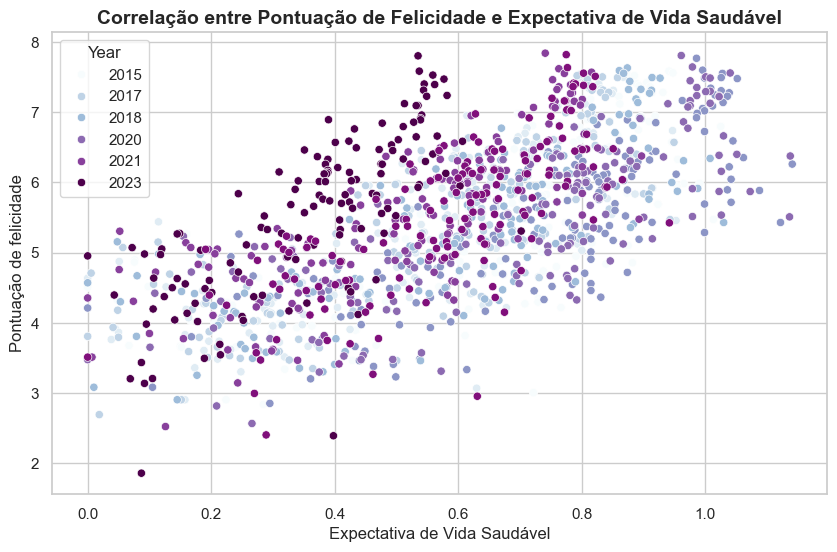

In [140]:
plt.figure(figsize=(10, 6))  # Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
sns.scatterplot(x="healthy_life_expectancy", y='happiness_score', data=df_unificado, hue='Year', palette='BuPu')  # Cria um gráfico no eixo x e 'Score' no eixo y, usando os dados do DataFrame
plt.title("Correlação entre Pontuação de Felicidade e Expectativa de Vida Saudável", fontsize=14, fontweight="bold")  # Define o título do gráfico
plt.xlabel("Expectativa de Vida Saudável")  # Define o rótulo do eixo x
plt.ylabel("Pontuação de felicidade")  # Define o rótulo do eixo y


plt.show()  # Exibe o gráfico na tela

6. Gráfico da correlação entre Felicidade e Generosidade

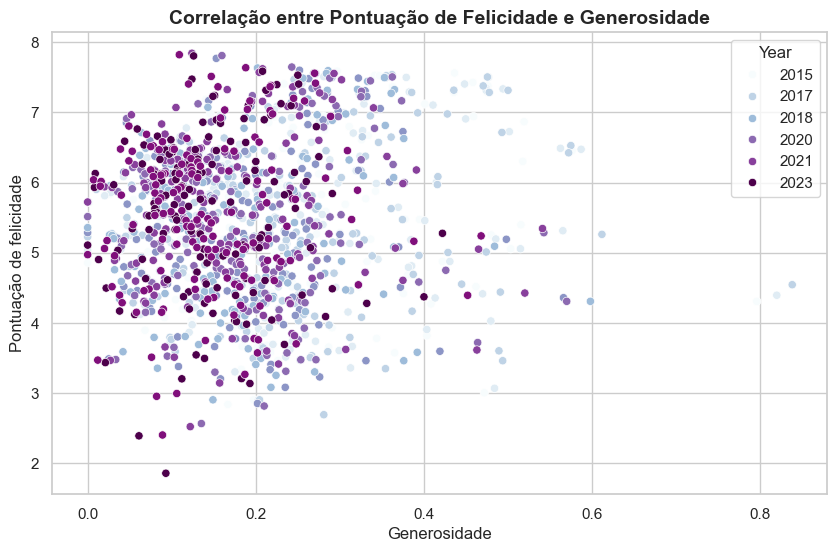

In [141]:
plt.figure(figsize=(10, 6))  # Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
sns.scatterplot(x="generosity", y='happiness_score', data=df_unificado, hue='Year', palette='BuPu')  # Cria um gráfico no eixo x e 'Score' no eixo y, usando os dados do DataFrame
plt.title("Correlação entre Pontuação de Felicidade e Generosidade", fontsize=14, fontweight="bold")  # Define o título do gráfico
plt.xlabel("Generosidade")  # Define o rótulo do eixo x
plt.ylabel("Pontuação de felicidade")  # Define o rótulo do eixo y


plt.show()  # Exibe o gráfico na tela

7. Gráfico da Correlação entre Felicidade e a Percepção de Corrupção

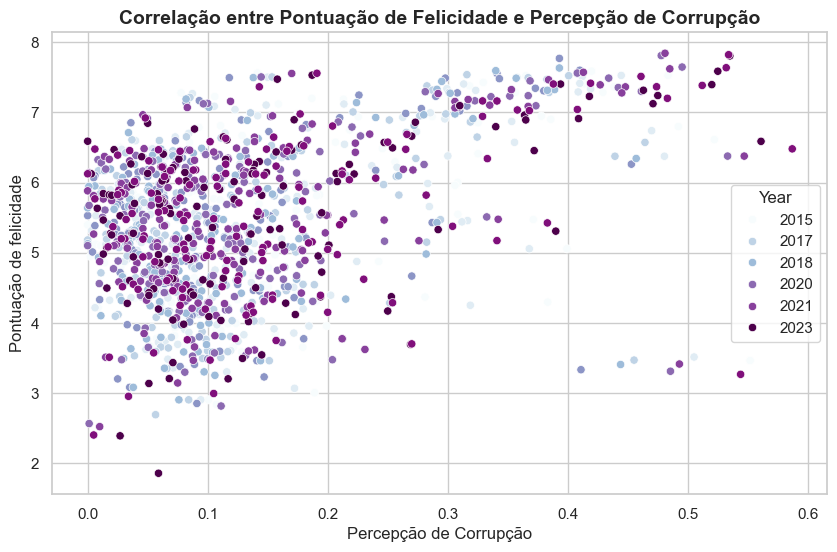

In [142]:
plt.figure(figsize=(10, 6))  # Cria uma nova figura para o gráfico com o tamanho especificado (10 polegadas de largura por 6 polegadas de altura)
sns.scatterplot(x="perceptions_of_corruption", y='happiness_score', data=df_unificado, hue='Year', palette='BuPu')  # Cria um gráfico no eixo x e 'Score' no eixo y, usando os dados do DataFrame
plt.title("Correlação entre Pontuação de Felicidade e Percepção de Corrupção", fontsize=14, fontweight="bold")  # Define o título do gráfico
plt.xlabel("Percepção de Corrupção")  # Define o rótulo do eixo x
plt.ylabel("Pontuação de felicidade")  # Define o rótulo do eixo y


plt.show()  # Exibe o gráfico na tela

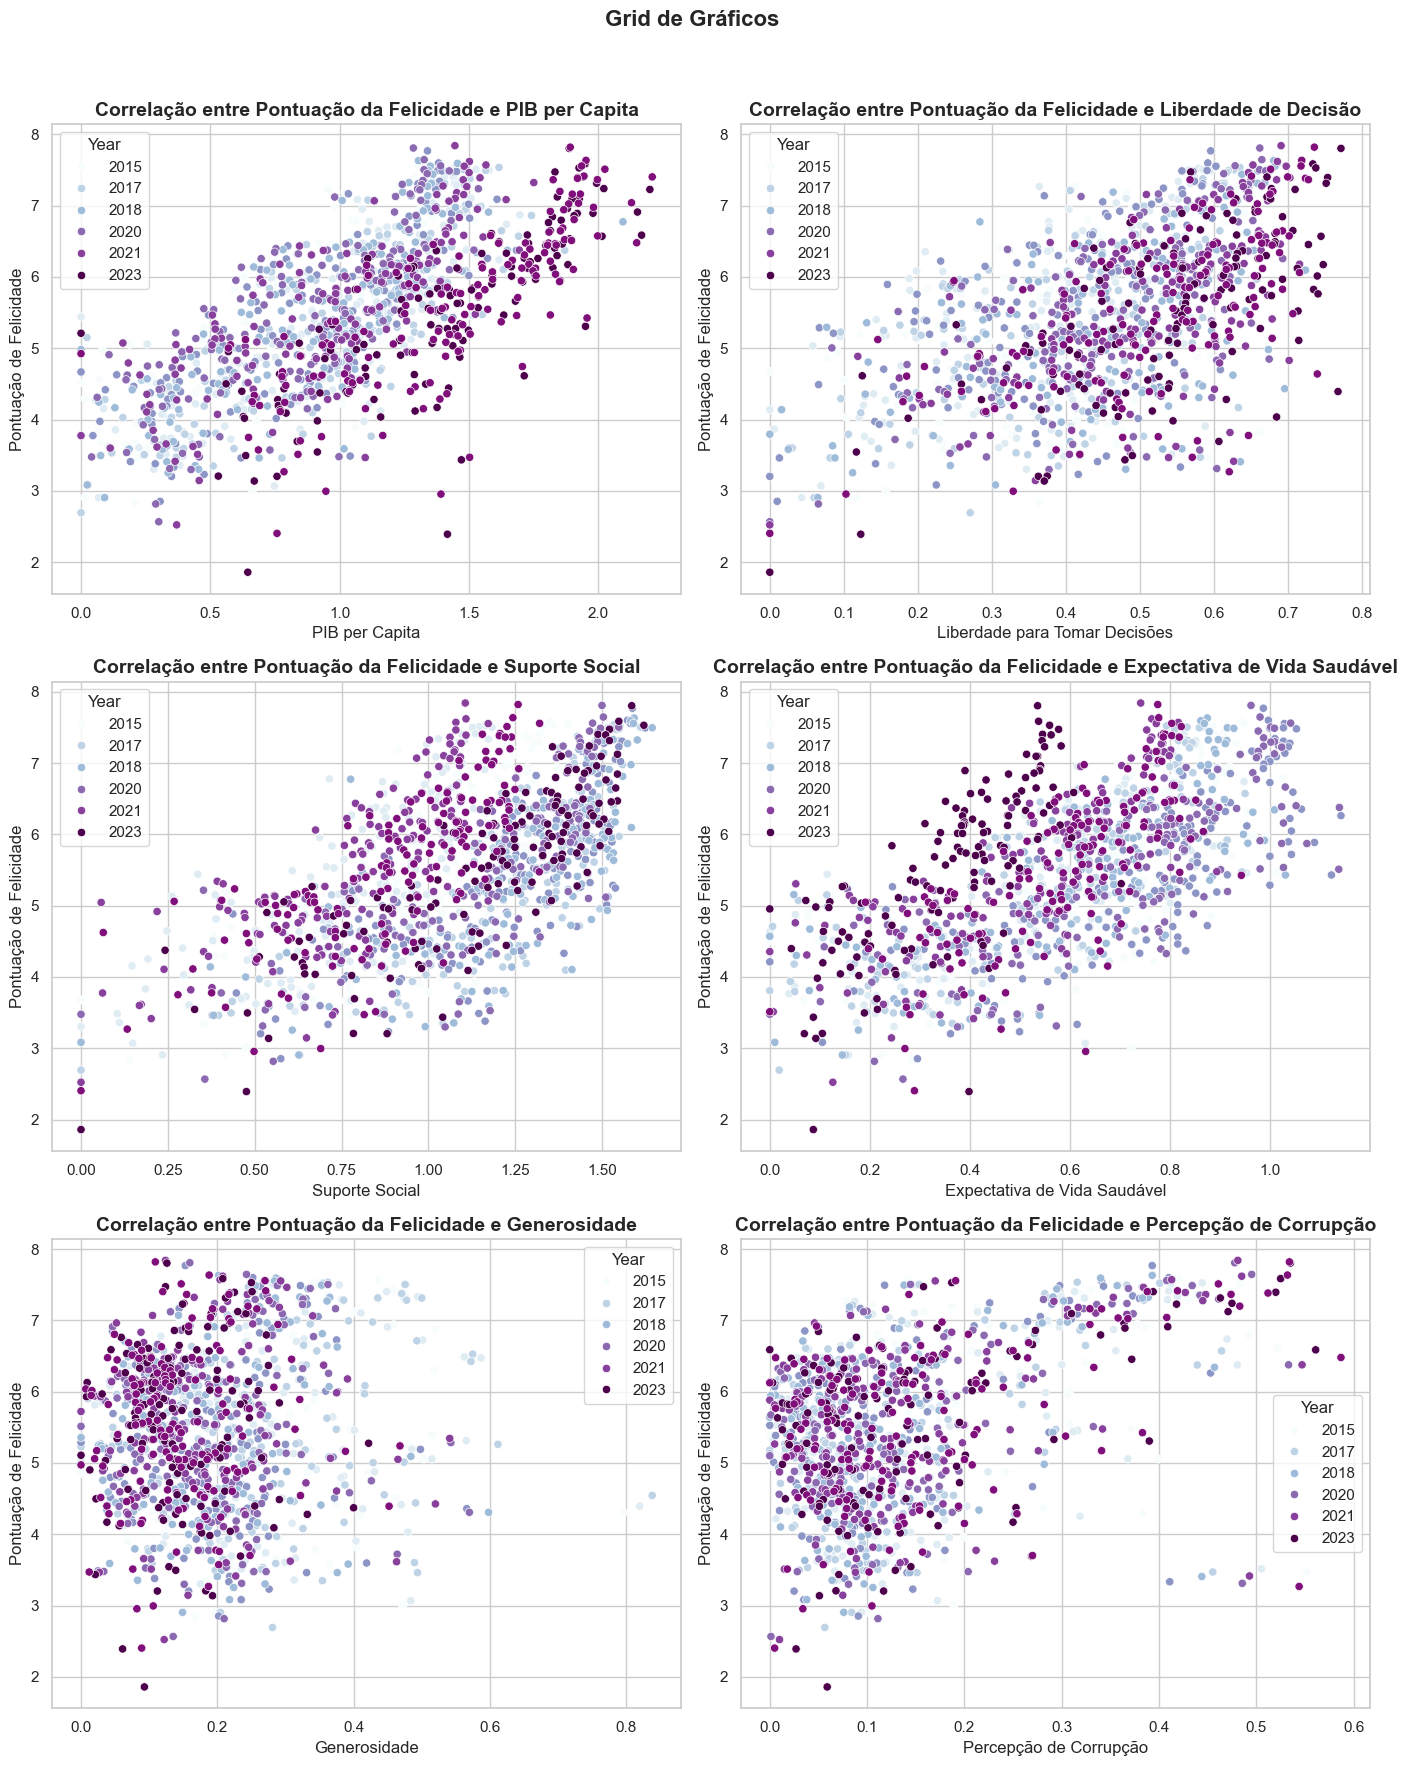

In [150]:
# Aqui, para permitir uma comparação entre a influência dos parâmetros, decidimos colocá-los em uma "página" única, na verdade um grid unificado, porque aí conseguimos analisá-los lado a lado.
#Para isso utilizamos a função subplots do Pyplot e determinamos que queríamos 3 linhas e 2 colunas (primeiros parâmetros passados) bem como o tamanho total da figura.
#Depois, copiamos o código dos gráficos criados acima, mas tiramos os parâmetros de individualização (ex: figsize, e os plt que vinham antes de cada elemento). Nesse caso, para funcionar, precisamos especificar o axs e usar um set_, aí ele consegue construir o visual que almejávamos.


fig, axs = plt.subplots(3, 2, figsize=(14, 18))  # 3 linhas, 2 colunas
fig.suptitle('Grid de Gráficos', fontsize=16, fontweight='bold')  # Título geral da figura

# Gráfico 1: Felicidade x PIB
sns.scatterplot(x='gdp_per_capita', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[0, 0])
axs[0, 0].set_title("Correlação entre Pontuação da Felicidade e PIB per Capita", fontsize=14, fontweight="bold")
axs[0, 0].set_xlabel('PIB per Capita')
axs[0, 0].set_ylabel("Pontuação de Felicidade")


# Gráfico 2: Felicidade x Liberdade de Escolhas
sns.scatterplot(x='freedom_to_make_life_choices', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[0, 1])
axs[0, 1].set_title("Correlação entre Pontuação da Felicidade e Liberdade de Decisão", fontsize=14, fontweight="bold")
axs[0, 1].set_xlabel('Liberdade para Tomar Decisões')
axs[0, 1].set_ylabel("Pontuação de Felicidade")

# Gráfico 3: Felicidade x Suporte Social
sns.scatterplot(x='social_support', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[1, 0])
axs[1, 0].set_title("Correlação entre Pontuação da Felicidade e Suporte Social", fontsize=14, fontweight="bold")
axs[1, 0].set_xlabel('Suporte Social')
axs[1, 0].set_ylabel("Pontuação de Felicidade")

# Gráfico 4: Felicidade x Expectativa de Vida Saudável
sns.scatterplot(x='healthy_life_expectancy', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[1, 1])
axs[1, 1].set_title("Correlação entre Pontuação da Felicidade e Expectativa de Vida Saudável", fontsize=14, fontweight="bold")
axs[1, 1].set_xlabel("Expectativa de Vida Saudável")
axs[1, 1].set_ylabel("Pontuação de Felicidade")

# Gráfico 5: Felicidade x Generosidade
sns.scatterplot(x='generosity', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[2, 0])
axs[2, 0].set_title("Correlação entre Pontuação da Felicidade e Generosidade", fontsize=14, fontweight="bold")
axs[2, 0].set_xlabel("Generosidade")
axs[2, 0].set_ylabel("Pontuação de Felicidade")

# Gráfico 6: Felicidade x Percepção de Corrupção
sns.scatterplot(x='perceptions_of_corruption', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[2, 1])
axs[2, 1].set_title("Correlação entre Pontuação da Felicidade e Percepção de Corrupção", fontsize=14, fontweight="bold")
axs[2, 1].set_xlabel("Percepção de Corrupção")
axs[2, 1].set_ylabel("Pontuação de Felicidade")

# Essa linha abaixo ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout para o título geral não sobrepor os gráficos

# Exibir os gráficos
plt.show()

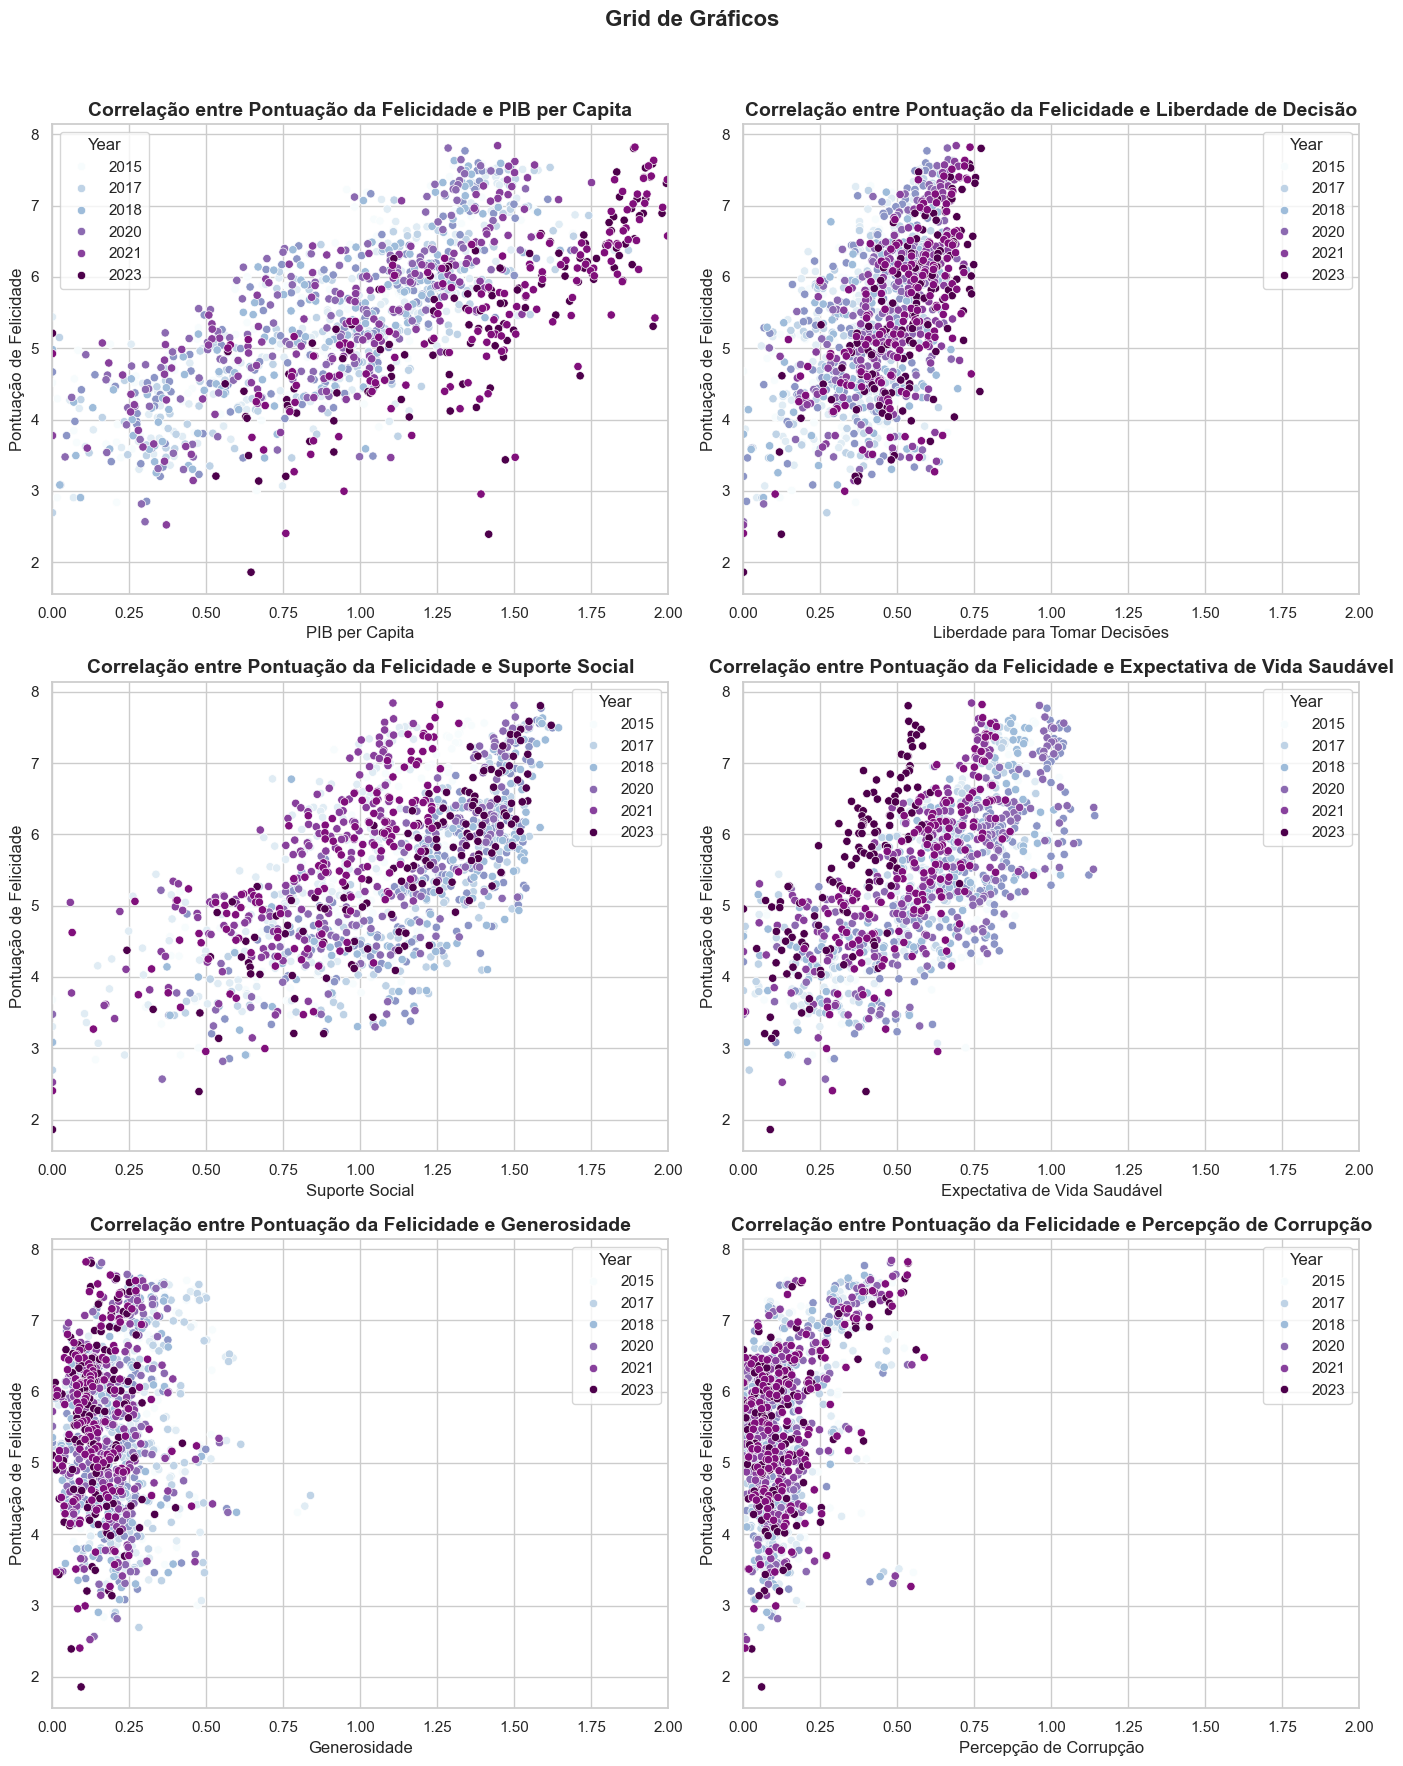

In [149]:
#Depois de plotar a primeira vez, percebemos que não podemos comparar esses parâmetros entre si se eles não estiverem na mesma "escala", então optamos por padronizar o eixo Y para que todos estejam em um intervalo de 0 a 2 (dado pela linha: axs[n, n].set_xlim(0, 2))
#Porém, analisando, percebemos que não poderia ser considerado assim, uma vez que se aquele parâmetro não vai até "2", analisá-lo nessa escala nos levaria ao erro (como se ele não fosse importante), ao passo que analisando-o na distribuição acima, estamos analisando o parâmetro distribuído de 0 a 100% dele.

fig, axs = plt.subplots(3, 2, figsize=(14, 18))  # 3 linhas, 2 colunas
fig.suptitle('Grid de Gráficos', fontsize=16, fontweight='bold')  # Título geral da figura

# Gráfico 1: Felicidade x PIB
sns.scatterplot(x='gdp_per_capita', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[0, 0])
axs[0, 0].set_title("Correlação entre Pontuação da Felicidade e PIB per Capita", fontsize=14, fontweight="bold")
axs[0, 0].set_xlabel('PIB per Capita')
axs[0, 0].set_ylabel("Pontuação de Felicidade")
axs[0, 0].set_xlim(0, 2)  # Definir o intervalo do eixo x

# Gráfico 2: Felicidade x Liberdade de Escolhas
sns.scatterplot(x='freedom_to_make_life_choices', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[0, 1])
axs[0, 1].set_title("Correlação entre Pontuação da Felicidade e Liberdade de Decisão", fontsize=14, fontweight="bold")
axs[0, 1].set_xlabel('Liberdade para Tomar Decisões')
axs[0, 1].set_ylabel("Pontuação de Felicidade")
axs[0, 1].set_xlim(0, 2)  # Definir o intervalo do eixo x

# Gráfico 3: Felicidade x Suporte Social
sns.scatterplot(x='social_support', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[1, 0])
axs[1, 0].set_title("Correlação entre Pontuação da Felicidade e Suporte Social", fontsize=14, fontweight="bold")
axs[1, 0].set_xlabel('Suporte Social')
axs[1, 0].set_ylabel("Pontuação de Felicidade")
axs[1, 0].set_xlim(0, 2)  # Definir o intervalo do eixo x

# Gráfico 4: Felicidade x Expectativa de Vida Saudável
sns.scatterplot(x='healthy_life_expectancy', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[1, 1])
axs[1, 1].set_title("Correlação entre Pontuação da Felicidade e Expectativa de Vida Saudável", fontsize=14, fontweight="bold")
axs[1, 1].set_xlabel("Expectativa de Vida Saudável")
axs[1, 1].set_ylabel("Pontuação de Felicidade")
axs[1, 1].set_xlim(0, 2)  # Definir o intervalo do eixo x

# Gráfico 5: Felicidade x Generosidade
sns.scatterplot(x='generosity', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[2, 0])
axs[2, 0].set_title("Correlação entre Pontuação da Felicidade e Generosidade", fontsize=14, fontweight="bold")
axs[2, 0].set_xlabel("Generosidade")
axs[2, 0].set_ylabel("Pontuação de Felicidade")
axs[2, 0].set_xlim(0, 2)  # Definir o intervalo do eixo x

# Gráfico 6: Felicidade x Percepção de Corrupção
sns.scatterplot(x='perceptions_of_corruption', y='happiness_score', data=df_unificado, hue='Year', palette='BuPu', ax=axs[2, 1])
axs[2, 1].set_title("Correlação entre Pontuação da Felicidade e Percepção de Corrupção", fontsize=14, fontweight="bold")
axs[2, 1].set_xlabel("Percepção de Corrupção")
axs[2, 1].set_ylabel("Pontuação de Felicidade")
axs[2, 1].set_xlim(0, 2)  # Definir o intervalo do eixo x

# Essa linha abaixo ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout para o título geral não sobrepor os gráficos

# Exibir os gráficos
plt.show()

#OBS: DEIXAMOS O GRÁFICO SÓ PRA MOSTRAR NOSSA ANÁLISE MESMO

#EXTRA

In [195]:
#Aqui vamos criar um novo dataframe usando as funções internas do pandas para limpar os dados e deixar apenas com países que aparecem todos os anos

anos_disponiveis = {2015, 2016, 2017, 2018, 2019,2020,2021,2022,2023} #aqui salvamos um conjunto com os anos entre 2015 e 2023 porque vamos usar isso depois

df_limpo = df_unificado.dropna() #decidimos remover os nulos apenas para essa análise
df_paises_todos_anos = df_limpo.groupby("country")["Year"].nunique() #aqui estamos criando um DataFrame temporário que agrupa os países e lista os anos em que aquele país apareceu uma única vez (isso exclui também se ele apareceu mais de uma vez indevidamente)
df_paises_todos_anos = df_paises_todos_anos[df_paises_todos_anos == len(anos_disponiveis)] #aqui ele "reforma" ou atualiza esse df temporário para que só os países que apareceram o mesmo número de vezes dos anos analisados sejam considerados, ou seja, se o valor for 9 - ele retorna um df simples com o nome dos países e o número de vezes do lado
df_final = df_limpo[df_limpo["country"].isin(df_paises_todos_anos.index)] #por fim fazemos então com que o código crie um df final contendo apenas os países que aparecem apenas nessa lista de cima (ou seja, só países que apareceram 9 vezes)

df_final.describe()

,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,Year
count,1136.000000,1136.000000,1136.000000,1136.000000,1136.000000,1136.000000,1136.000000,1136.000000
mean,5.556389,1.057407,1.069889,0.610327,0.463034,0.196238,0.128793,2018.999120
std,1.093595,0.434317,0.321948,0.238429,0.148591,0.113177,0.113358,2.581022
min,1.859000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,4.717750,0.768803,0.869010,0.434680,0.374696,0.117262,0.053504,2017.000000
50%,5.601500,1.074864,1.098484,0.637262,0.477145,0.182344,0.089000,2019.000000
75%,6.343250,1.355954,1.323715,0.792832,0.574598,0.252740,0.158225,2021.000000
max,7.842000,2.209000,1.644000,1.141000,0.772000,0.838075,0.587000,2023.000000


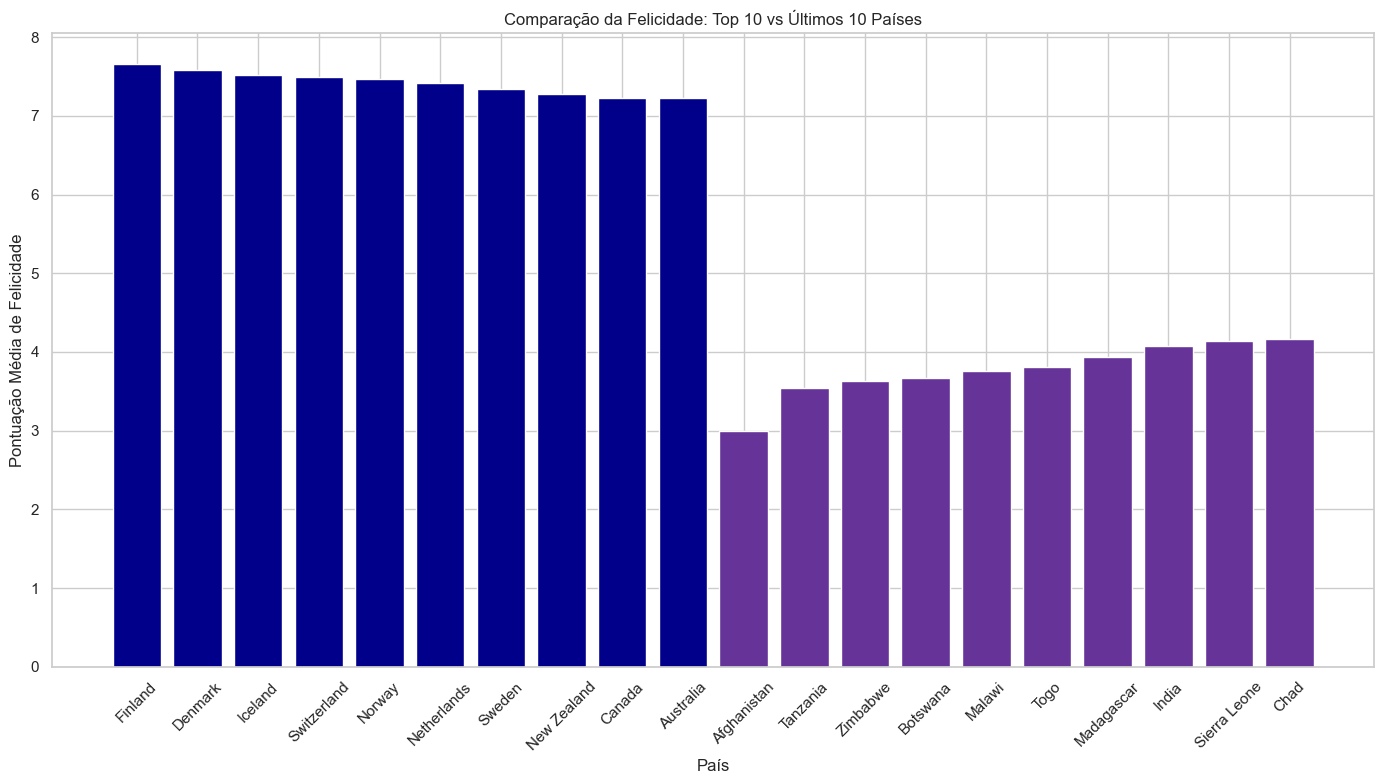

In [208]:
#Aqui vamos pegar esse df_final, tirar duas amostras dos países com maiores médias e países com menores médias, unificá-los e fazer um gráfico


def comparar_paises_felicidade(df):

    media_felicidade = df.groupby('country')['happiness_score'].mean().reset_index()#aqui calculamos a média de felicidade dos países para todos os anos
    top_10 = media_felicidade.nlargest(10, 'happiness_score') #essa função nlargest analisa os 10 países com as maiores notas médias do score de felicidade
    bottom_10 = media_felicidade.nsmallest(10, 'happiness_score') #da mesma forma, o nsmallest pega os 10 países com as menores notas médias do score de felicidade
    amostras_combinadas = pd.concat([top_10, bottom_10], ignore_index=True) #para a análise que quisemos fazer não fazia muito sentido usar o merge, deixamos isso de lado e usamos o concat
    
    # 5. Abaixo configuramos o gráfico pra exibir o resultado das  10 maiores e 10 menores médias ao longo dos anos
    plt.figure(figsize=(14, 8))
    plt.bar(amostras_combinadas['country'], amostras_combinadas['happiness_score'], color=['darkblue'] * 10 + ['rebeccapurple'] * 10)
    plt.xticks(rotation=45)
    plt.title('Comparação da Felicidade: Top 10 vs Últimos 10 Países')
    plt.xlabel('País')
    plt.ylabel('Pontuação Média de Felicidade')
    plt.tight_layout()
    plt.show()

comparar_paises_felicidade(df_final)




TESTE DE HIPÓTESE
H0: Não há relação entre o PIB e o Score de Felicidade
H1: Há relação entre o PIB e o Score de Felicidade (ou seja, PIBs maiores equivalem a níveis de felicidade maiores)

In [218]:
#Usamos o teste de Pearson porque ele permite avaliar a força da relação entre duas variáveis, nesse caso queríamos analisar se a relação entre o PIB e o Score realmente eram fortes ou não. Mas é preciso destacar que normalmente, por padrão, a hipótese nula típica é a de que não há relação

correlation, p_value = pearsonr(df_final["gdp_per_capita"], df_final["happiness_score"])

print(f"Coeficiente de Correlação: {correlation:.3f}")
print(f"Valor p: {p_value:.3f}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. Existe uma correlação significativa entre PIB e score de felicidade, ou seja, o PIB influencia no Score de Felicidade, sim.")
else:
    print("Não rejeitamos a hipótese nula. Não há correlação significativa entre PIB e score de felicidade, ou seja, o PIB não influencia no Score de Felicidade")

Coeficiente de Correlação: 0.702
Valor p: 0.000
Rejeitamos a hipótese nula. Existe uma correlação significativa entre PIB e score de felicidade, ou seja, o PIB influencia no Score de Felicidade, sim.
